# ELL409 Course Project
## Friend Recommendation and Ranking using Graph Neural Networks
### - Yadvendra Gurjar (2022EE31764)

<div style="display: flex; justify-content: space-around;">
  <img src="img/paper_1.jpeg" alt="Image 1" style="width: 45%;"/>
</div>

# 1 Graph Neural Networks (GNNs)

A **graph** 𝒢 = (𝒱, ℰ) consists of nodes 𝒱 and edges ℰ (with optional edge features eᵤᵥ).  
A GNN learns node (or graph) embeddings by **iteratively aggregating** information from each node’s neighbors.

---

### Message‐Passing Framework

At layer _t_, each node _v_ updates its hidden state $h_v^t$:

1. **Message computation**  
   $mᵥ^t = ∑_{ᵤ∈𝒩(v)} M(h_v^{t−1}, h_u^{t−1}, eᵤᵥ)$

2. **State update**  
   $h_v^t = U(h_v^{t−1}, mᵥ^t)$

Here M(·) and U(·) are learnable functions (e.g. small MLPs).

---

> **Key idea:** at each layer, nodes “talk” to their neighbors via learnable message and update functions, building richer representations of graph structure.  


# 2 Problem Statement

<div style="text-align: center;">
  <img src="img/problem_statement.jpeg" alt="Problem Statement" style="width: 70%;"/>
</div>

# 3 User Features

We extract user attributes spanning a total of **K = 3 modalities**, which include profile attributes, in-app interests , and user engagement activities. These modalities are described in detail below:

### **Profile Attributes**
A set of (mostly) static demographic features describing the user, including age, gender, recent locations, languages, etc., that are listed or inferred from their profile.

### **Content Interests**
A real-valued feature vector describing the textual content (e.g., posts, stories) interacted with by the user within the platform, such as topics of stories viewed by the user.

### **Engagement Activity**
Aggregated metrics capturing the number of in-app direct and indirect engagements by the user, such as text messages, snaps, and comments on posts, with other friends over different time ranges.

These multi-modal user features, along with pairwise link communication features, are essential for understanding the temporally evolving friendship graph and enabling multi-faceted friend ranking.

<div style="text-align: center;">
  <img src="img/features.jpeg" alt="Problem Statement" style="width: 70%;"/>
</div>

# 4 The GraFRank Model

We hope to accomplish the following goal:

**Leverage user features** $\{x_v : v\in\mathcal{V}\}$ and **friendship graphs** $\{G^k : 1 \leq k \leq 10\}$, to **generate user representations** $\{h_v \in \mathbb{R}^D : v\in \mathcal{V}\}$ that **facilitate friend suggestion** tasks of candidate retrieval and **re-ranking**.

**The specific tasks include:** 
- candidate retrieval via link prediction
- - we first generate a list of top $N$ possible friend recommendations. 
- candidate ranking through a reranking of the retrieval pool
- - we re-rank a subset of these recommendations to obtain the final top $n$ recommendations, where $n << N$.

---

## 4.1 The GraFRankConv Layer

- Each modality varies in its level of graph homophily. 
- Hence, we must learn a modality-specific representation $z_u^k \in 	\mathbb{R}^D$ for node $u\in V$. 
- Thus, after the modality-specific neighborhood aggregation, we will have computed $K$ representations $\{z_{u}^1,...,z_{u}^K\}$, where $z_{u}^k \in 	\mathbb{R}^D$ for each node. 
- The GraFRankConv Layer consists of two steps: message propagation and message aggregation.

## Message Propagation:

- we aggregate the K modality features $\{\textbf{x}^k_v, v \in N(u) \} $ for node $u$. 
- To quantify the importance of "friendship" connections, we have an attention coefficient between nodes $u$ and $v$ with respect to modality $k$: $$\alpha^k(u,v)=\textrm{LeakyRELU}(\textbf{a}^T_k(\textbf{W}_1^k\textbf{x}^k_u||\textbf{W}_1^k\textbf{x}^k_v))$$ (where $||$ is concatenation and $\textbf{W}_1^k \in 	\mathbb{R}^{D_k \times D}$ is a shared weight matrix for all users). 
- We then normalize all $\alpha^k(u,v)$ using the softmax function.
- The message $m_{u\leftarrow v}^k \in \mathbb{R}^D$ propagated from user $v$ to user $u$ is $m_{u\leftarrow v}^k = W_1^k x_v^{k}$. 
- We can then compute the the embedding $z_u^k=\sum_{v\in N(u)}\alpha^k(u,v)m_{u\leftarrow v}^k$, which is the weighted average of the messages from $u$'s neighbors.


## Message Aggregation:

- We use messages from both friends and from self-connections $m_{u\leftarrow u}^k = W_1^k x_u^{x,k}$. 
- The self connections are for keeping information of the original features. 
- We transform the concatenated embedding (ego-network and self-representation) through a dense layer $F_{\theta}^k$, defined by:

$z_u^{k, (L)} = F_{\theta}^k\big(m_{u\leftarrow u}^k, z_u^{k, (L - 1)}\big)\\
= \sigma\big(W_a^k\big(z_u^{k, (L-1)}||m_{u\leftarrow u}^k \big) + b_a\big)$

$W_a^k \in \mathbb{R}^{D \times D}$, $b_a, \in \mathbb{R}^D$ are trainable parameters of the aggregator, $L$ denotes the current layer, and $\sigma$ denotes the ELU activation function which allows messages to encode both positive and small negative signals.

---

## 4.2 Cross Modal Attention Layer
- The cross modal attention weights individually aim to understand the influence of each modality on the importance on the embedding of each node.

We learn softmax normalized modality attention weights $\beta_u^{k}(t)$ by using a two-layer Multi-Layer Perceptron, defined by:
$$\beta_u^{k}(t) = \frac{\exp(a_m^TW_mz_{u,L}^k + b_m)}{\sum_k exp(a_m^TW_mz_{u,L}^k+b_m)}$$
with weights $W_m\in \mathbb{R}^{D\times D}, a_m \in \mathbb{R}^D$ and scalar bias $b_m$. The final representation $h_u{(t)}\in \mathbb{R}^D$ of user $u$ is computed by a weighted
aggregation of the layer-L modality-specific user representations $\{z_{u,L}^1,...z_{u_L}^K\}$, guided by modality weights $\beta_u^{k}(t)$, defined by

$$h_u(t) = \sum_{k=1}^K \beta_u^{k}(t)W_mz_{u,l}^k$$

---

In [27]:
import torch
print(f"torch version = <{torch.__version__}>")
import torch_geometric
print(f"torch geometric version = <{torch_geometric.__version__}>")
import numpy as np
import pandas as pd
import warnings
from copy import deepcopy
from torch_geometric.utils.convert import from_networkx
from torch_geometric.utils import train_test_split_edges
from torch.nn import BCEWithLogitsLoss
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, RocCurveDisplay

torch version = <2.6.0+cpu>
torch geometric version = <2.6.1>


# 5 Facebook Social Circles Dataset

### Source
The dataset is provided by the Stanford Network Analysis Project (SNAP) and can be accessed at [https://snap.stanford.edu/data/ego-Facebook.html](https://snap.stanford.edu/data/ego-Facebook.html).

### Description
This dataset contains anonymized Facebook data collected from survey participants using the Facebook app. It represents the social circles (ego networks) of users, where each ego network consists of a central user (ego) and their friends. The dataset is undirected and unweighted, meaning that all connections are mutual and have no associated weights.

### Data Storage
- **Graph Representation**: The dataset is stored as a collection of ego networks, where each ego network is represented as a graph.
- **Files**:
  - `facebook_combined.txt`: Contains the edges of the combined graph, where each line represents an edge between two nodes (user IDs).
  - `ego/*.edges`: Contains the edges for each ego network, where each file corresponds to a specific ego.
  - `ego/*.feat`: Contains the features of nodes in each ego network. Each row corresponds to a node, and the columns represent binary features.
  - `ego/*.featnames`: Contains the names of the features in the `.feat` files, providing a mapping of feature indices to their descriptions.

### Key Characteristics
- **Nodes**: Represent Facebook users.
- **Edges**: Represent friendships between users.
- **Features**: Binary attributes of users, such as profile information (e.g., education, location, etc.).
- **Ego Networks**: Each ego network is centered around a specific user and includes their friends and the connections between them.


### Note:
- The data has been anonymized to protect user privacy.
- The dataset is suitable for studying the structure and dynamics of social networks.

---
## 5.1 Loading the Dataset

Our data loading code will load the dataset into a single NetworkX graph. We then convert the NetworkX graph to a PyG graph object, which we feed into the GNN.

The process of loading the dataset and converting it into the required data structure for use in the Graph Neural Network (GNN) is a complex and intricate task. To streamline this process and ensure modularity, the complete implementation for dataset loading and conversion has been encapsulated in the `src.dataset` module. 

Here, we simply utilize the functionality provided by `src.dataset` to load the dataset efficiently.


In [28]:
from src.dataset import *

"""
Load the dataset
"""
print("Loading network...")
feat_file_name = "Data/feature_map.txt"
dataset_folder_path = "Data"
load_network(dataset_folder_path)
print("Loading done.")

Loading network...
Loading done.


In [29]:
# Print out some node features for fun.
print(network.nodes[0])
print(len(network.nodes[0]['node_feature']))
print(network.nodes[400])
print(len(network.nodes[400]['node_feature']))

{'node_feature': tensor([1., 1., 1.,  ..., 0., 0., 0.]), 'ego_id': 0}
1283
{'node_feature': tensor([2., 1., 1.,  ..., 0., 0., 0.]), 'ego_id': 348}
1283


## 5.2 Explore the dataset!

We have successfully loaded the dataset. Now we will explore the dataset. Notice how there are (~10) distinct clusters in the graph. This is because their are 10 ego networks in this graph.

In [30]:
import matplotlib.pyplot as plt
from pylab import show

Graph with 4039 nodes and 88234 edges


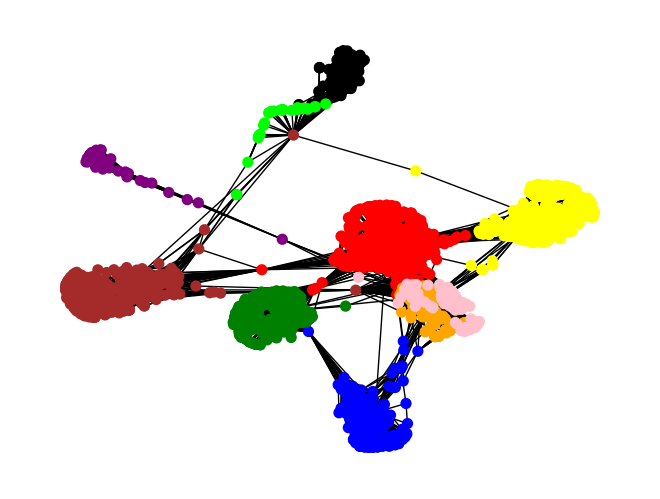

In [31]:
def make_color_map(network):
  colors = ['blue', 'red', 'yellow', 'green', 'brown',
            'orange', 'purple', 'pink', 'black', 'lime']
  color_map = []
  ego_nodes = []
  for node_idx, node_attr in network.nodes(data=True):
    ego_id = node_attr['ego_id']
    if ego_id not in ego_nodes:
      ego_nodes.append(ego_id)
    color_map.append(colors[ego_nodes.index(ego_id)])
  return color_map

# Color each node based on which ego network it belongs to so we can distinguish.
print(network)
nx.draw(network, node_color=make_color_map(network), node_size=50)

# 6 READY TO TRAIN
- The GraFRank paper used a proprietary Snapchat dataset with four modalities. 
- The Facebook dataset is not a multimodal dataset. 
- To simulate multimodal learning, we split nodes' feature vectors into four parts (pseudo-modalities) to simulate four modalities. *(The GraFRank authors do this to the CORA dataset in their GitHub repository for the same reason.)*

## 6.1 Splitting the dataset (**Transductive Split**)

- Need test train and validation split. 
- But splitting a graph is a non-trivial task (*especially for link prediction*)

### Supervision Edges
We try and do is hide different edges from GraFrank at test, validation and train time, so that it never learns to use those edges or about their existence when it is training. We can then predict these unseen edges to calculate the loss. These unseen edges are known as supervision edges. 

### Message Edges
However, we still need some edges in order to aggregate information in the graph. These retained edges will not be used for supervision and will exist only for message passing, and are thus known as message edges.

Step-by-step:

- At training time: only the training message edges are seen by the GNN and used to predict the with the training supervision edges.
- At validation time: only the training message edges and training supervision edges are seen by the GNN, and the validation supervision edges are predicted.
- At test time: the training message edges, training supervision edges and validation supervision edges are seen by the GNN, and the **test supervision edges are predicted** (and therfore unseen).

This is known as a transductive split due to the disjoint nature of each edge set with each other

In [32]:
from src.model import *

device = torch.device('cpu')
warnings.filterwarnings("ignore") # we dont want to hear PyG scream

# Convert networkx graph to PyG; convert data to cpu
myGraph = deepcopy(network).to_directed()
data = from_networkx(myGraph)
data.to('cpu')

#splitting the dataset
data = train_test_split_edges(data, val_ratio=0.1, test_ratio=0.1)
data.to("cpu")

## input dim list assumes that the node features are first
## 1283 is the number of node features
## since we don't really have modalities in this dataset, and
## GraFrank pays special attention to them, we create pseudo modalities
## by partitioning the edge features into 4 different sets =P
model = GraFrank(1283, hidden_channels=64, edge_channels=5, num_layers=4,
                 input_dim_list=[350, 350, 350, 233])
model = model.to("cpu")

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
def get_link_labels(pos_edge_index, neg_edge_index, devce):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    # used as our ground truth
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=devce)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels


def train_model():
    model.train()

    # sampling negative edges
    """
    if we only train on positive edges (supervision edges) then our GNN wouldvery quickly learn to output
    all positive predictions. Thus we sample non-existent edges (in any of the splits) and label them as
    negative (false) edges and use them to train the GNN
    """
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, # positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)).to(device) # number of neg_sample equal to number of pos_edges

    optimizer.zero_grad()

    data.train_pos_edge_index.to(device)

    # adding the adjacency representations of both edge types together
    edge_index = torch.cat([data.train_pos_edge_index, neg_edge_index], dim=-1)

    x = data.node_feature
    # x = torch.stack(data.node_feature)
    x.to(device)
    # edge_feature = torch.stack(data.edge_feature)
    edge_feature = data.edge_feature
    edge_feature.to(device)

    # creating embeddings for all nodes
    out = model.full_forward(x, data.train_pos_edge_index, edge_feature[:data.train_pos_edge_index.shape[1]])

    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index, "cpu")

    # retaining only the dot products for the nodes that span our training edges
    logits = (out[edge_index[0]] * out[edge_index[1]]).sum(dim=-1)

    # training with simple binary cross entropy
    loss = BCEWithLogitsLoss()(logits, link_labels)
    loss.backward()
    optimizer.step()

    train_acc = roc_auc_score(link_labels.cpu(), logits.sigmoid().flatten().cpu().detach().numpy())

    # torch.cpu.empty_cache()
    return loss, train_acc

def test_model(output=False):
    # defining the test function
    # very similar to the train function but the sampling was already done for us
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        # x = torch.stack(data.node_feature)
        x = data.node_feature
        x.to("cpu")
        # edge_feature = torch.stack(data.edge_feature)
        edge_feature = data.edge_feature
        edge_feature.to("cpu")

        out = model.full_forward(x, pos_edge_index, edge_feature[:pos_edge_index.shape[1]])
        link_labels = get_link_labels(pos_edge_index, neg_edge_index, "cpu")

        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)

        logits = (out[edge_index[0]] * out[edge_index[1]]).sum(dim=-1)

        loss = BCEWithLogitsLoss()(logits, link_labels)
        perfs.append(loss)
        link_probs = logits.sigmoid() # apply sigmoid        
        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.flatten().cpu().detach().numpy())) #compute roc_auc score
        if prefix=="test" and output:
          return perfs, link_labels.cpu(), link_probs.flatten().cpu().detach().numpy()
    return perfs

import torch
import pandas as pd
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import roc_auc_score

def test_model_and_save_csv(csv_path="predicted_links.csv"):
    model.eval()
    all_perfs = []
    
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        x = data.node_feature.to("cpu")
        edge_feature = data.edge_feature.to("cpu")

        out = model.full_forward(
            x, 
            pos_edge_index, 
            edge_feature[:pos_edge_index.shape[1]]
        )
        link_labels = get_link_labels(pos_edge_index, neg_edge_index, "cpu")
        
        # Stack positive then negative edges for joint scoring
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        logits = (out[edge_index[0]] * out[edge_index[1]]).sum(dim=1)
        probs = logits.sigmoid().cpu().detach().numpy()
        
        # Performance metrics
        loss = BCEWithLogitsLoss()(logits, link_labels)
        auc  = roc_auc_score(link_labels.cpu(), probs)
        all_perfs.extend([loss, auc])
        
        # If this is the test split, save predictions to CSV
        if prefix == "test":
            src = edge_index[0].cpu().numpy()
            tgt = edge_index[1].cpu().numpy()
            lbl = link_labels.cpu().numpy()
            
            df = pd.DataFrame({
                "ID1": src,
                "ID2": tgt,
                "label": lbl,
                "score": probs
            })
            df.to_csv(csv_path, index=False)
            print(f"Saved {len(df)} predicted links to {csv_path}")
    
    return all_perfs


## 7 Testing

GNN predict the existence of the link for both positive and negative edges. Unlike with the training example though, the negative sampling was already done for us and the edges are held in the data object we created, so we can simply predict using these edges to generate metrics.

In [34]:
print("Training the model...")
losses = []
train_accs = []
val_accs = []
test_accs = []
val_losses = []
test_losses = []

print_freq = 10 # print every 10 epochs
num_epochs = 80
for epoch in range(num_epochs+1):
    loss, train_acc = train_model()
    # torch.cpu.empty_cache()
    losses.append(loss)
    train_accs.append(train_acc)
    if epoch % print_freq == 0:
      print(f'Epoch: {epoch:03d}')
      print(f'Train Loss:\t{loss:.4f}\t\tTrain ROC_AUC:\t{train_acc:.4f}')
      test_acc = test_model()
      val_accs.append(test_acc[1])
      test_accs.append(test_acc[3])
      val_losses.append(test_acc[0])
      test_losses.append(test_acc[2])
      print(f'Val Loss:\t{val_losses[epoch//print_freq-1]:.4f}\t\tVal ROC_AUC:\t{val_accs[epoch//print_freq-1]:.4f}')
      print(f'Test Loss:\t{test_losses[epoch//print_freq-1]:.4f}\t\tTest ROC_AUC:\t{test_accs[epoch//print_freq-1]:.4f} ')
      print("---------------------------------------------")


Training the model...
Epoch: 000
Train Loss:	0.7146		Train ROC_AUC:	0.8326
Val Loss:	0.6622		Val ROC_AUC:	0.8648
Test Loss:	0.6618		Test ROC_AUC:	0.8641 
---------------------------------------------
Epoch: 010
Train Loss:	0.4825		Train ROC_AUC:	0.9322
Val Loss:	0.6622		Val ROC_AUC:	0.8648
Test Loss:	0.6618		Test ROC_AUC:	0.8641 
---------------------------------------------
Epoch: 020
Train Loss:	0.4638		Train ROC_AUC:	0.9410
Val Loss:	0.4850		Val ROC_AUC:	0.9412
Test Loss:	0.4849		Test ROC_AUC:	0.9407 
---------------------------------------------
Epoch: 030
Train Loss:	0.4485		Train ROC_AUC:	0.9487
Val Loss:	0.4650		Val ROC_AUC:	0.9478
Test Loss:	0.4661		Test ROC_AUC:	0.9470 
---------------------------------------------
Epoch: 040
Train Loss:	0.4414		Train ROC_AUC:	0.9521
Val Loss:	0.4573		Val ROC_AUC:	0.9495
Test Loss:	0.4609		Test ROC_AUC:	0.9485 
---------------------------------------------
Epoch: 050
Train Loss:	0.4394		Train ROC_AUC:	0.9549
Val Loss:	0.4659		Val ROC_AUC:	0.94

# 8 Model Evaluation


In [35]:
def generate_random_important_statistics():
  metrics, truths, preds = test_model(True)
  preds = np.rint(preds) # round to nearest integer so sklearn metrics can be used
  print("Test Accuracy:\t", accuracy_score(truths, preds))
  print("Test Precision:\t", precision_score(truths, preds))
  print("Test Recall:\t", recall_score(truths, preds))
  print("Test F1 Score:\t", f1_score(truths, preds))

generate_random_important_statistics()

Test Accuracy:	 0.8416071630964524
Test Precision:	 0.7642932304454577
Test Recall:	 0.9878726056896747
Test F1 Score:	 0.8618183615958867


**We do fairly well, predicting with over 80% accuracy**

# Plots

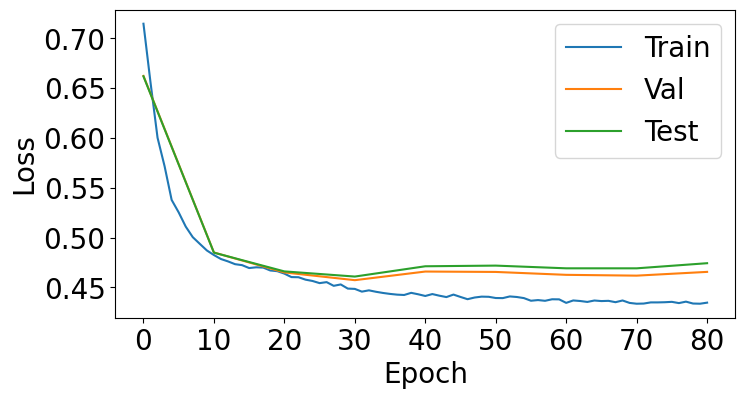

In [36]:
def plot_losses():
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))  # (15,8)

    # Detach tensors and move them to CPU before converting to NumPy
    ax.plot(range(num_epochs + 1), [loss.detach().cpu().numpy() for loss in losses], label="Train")
    ax.plot(range(0, num_epochs + 1, 10), [val_loss.detach().cpu().numpy() for val_loss in val_losses], label="Val")
    ax.plot(range(0, num_epochs + 1, 10), [test_loss.detach().cpu().numpy() for test_loss in test_losses], label="Test")

    ax.set_xlabel("Epoch", fontsize=20)
    ax.set_ylabel("Loss", fontsize=20)
    ax.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

plot_losses()


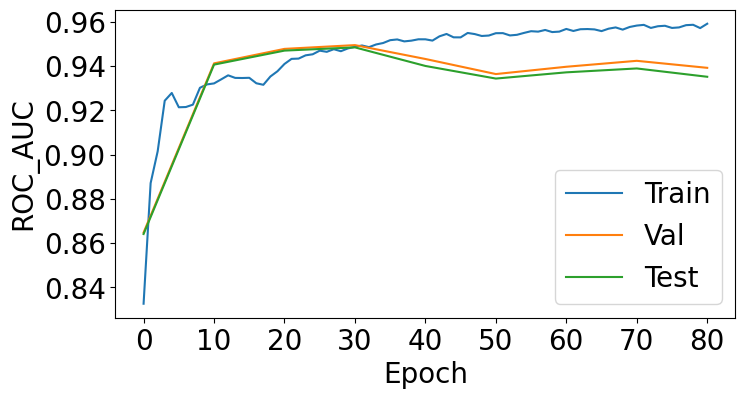

In [37]:
def plot_rocs():
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))  # (15, 8)
    ax.plot(range(0, num_epochs + 1), train_accs, label="Train")
    ax.plot(range(0, num_epochs + 1, 10), val_accs, label="Val")
    ax.plot(range(0, num_epochs + 1, 10), test_accs, label="Test")
    ax.set_xlabel("Epoch", fontsize=20)
    ax.set_ylabel("ROC_AUC", fontsize=20)
    ax.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)  # Corrected capitalization
    plt.show()

plot_rocs()


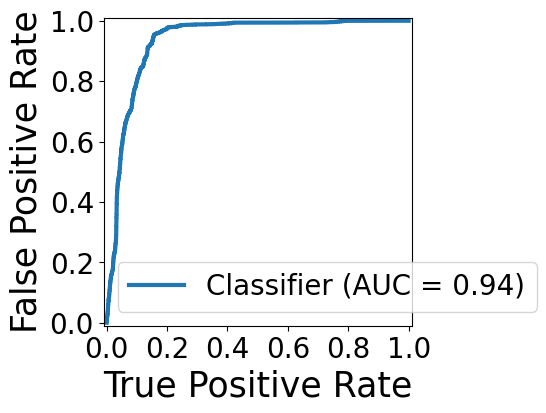

In [38]:
def plot_ROC():
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    metrics, truths, preds = test_model(True)  # Ensure test_model(True) returns the required values
    RocCurveDisplay.from_predictions(truths, preds, ax=ax, linewidth=3)
    ax.set_xlabel("True Positive Rate", fontsize=25)
    ax.set_ylabel("False Positive Rate", fontsize=25)
    ax.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)  # Corrected capitalization
    plt.show()

plot_ROC()


# Saving Predicted Links

In [39]:
perfs = test_model_and_save_csv("predicted_links.csv")


Saved 17646 predicted links to predicted_links.csv
